# **CNN Encoder Decoder with face_images** 

In the current python notebook, we have executed the construction of an autoencoder model, employing straightforward Convolutional Neural Networks (CNN) operations. The principal objective of this process is the reconstruction of color in facial images, utilizing their corresponding grayscale versions as the initial input.

# Import necessary libraries

In [1]:
import random
import matplotlib.pyplot as plt
import zipfile
import io
from google.colab import files
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import numpy as np
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import cv2
from skimage import color
import torch.nn as nn
import torchvision.transforms.functional as TF

# Connect to GPU if availble 

*Clear the CUDA memory cache. This releases all unoccupied cached memory so that those can be used by CUDA operations if necessary. This can help prevent the CUDA out-of-memory errors that can occur when the memory is filled up with cached, but unused data.*

In [ ]:

torch.cuda.empty_cache()

In [ ]:
# If this cell fails you need to change the runtime of your colab notebook to GPU
# Go to Runtime -> Change Runtime Type and select GPU
assert torch.cuda.is_available(), "GPU is not enabled"

#  Use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Utils

*Upload zip file with face images and create different folders to split the data into train and validation.*

In [2]:
uploaded = files.upload()

Saving DeepColorization-master.zip to DeepColorization-master.zip


In [3]:
# Specify the file name of the uploaded ZIP file
zip_filename = "DeepColorization-master.zip"

# Extract the contents of the ZIP file
with zipfile.ZipFile(io.BytesIO(uploaded[zip_filename]), "r") as zip_ref:
    zip_ref.extractall("face_images")

In [4]:
# Path to the extracted dataset folder
dataset_folder_path = "/content/face_images/DeepColorization-master/face_images"

# Get the list of image files in the dataset folder
image_files = [f for f in os.listdir(dataset_folder_path) if os.path.isfile(os.path.join(dataset_folder_path, f))]

In [5]:
# Create directories for training and validation sets
train_folder = "/content/dataset/train"
val_folder = "/content/dataset/val"

# Create the directories if they don't exist
os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)

In [6]:
# Shuffle the image files list
random.shuffle(image_files)

# Determine the split ratio (e.g., 80% for training, 20% for validation)
split_ratio = 0.8
split_index = int(len(image_files) * split_ratio)

# Split the image files list into training and validation sets
train_image_files = image_files[:split_index]
val_image_files = image_files[split_index:]

In [7]:
# Iterate through the training set image files
for i, image_name in enumerate(train_image_files):
    image_path = os.path.join(dataset_folder_path, image_name)
    image = Image.open(image_path)

    colored_image_path = os.path.join(train_folder, image_name)
    image.save(colored_image_path)

In [8]:
# Iterate through the validation set image files
for image_name in val_image_files:
    image_path = os.path.join(dataset_folder_path, image_name)
    image = Image.open(image_path)

    # Save the colored image in the validation folder
    colored_image_path = os.path.join(val_folder, image_name)
    image.save(colored_image_path)

# LAB Colourspace

*Create a class in order to apply the necessary transformations to the images.*

In [9]:
# Define the ColorizationDataset class that extends the PyTorch Dataset class
class ColorizationDataset(Dataset):
    # Initialize the ColorizationDataset object
    def __init__(self, root_dir, transform=None):
        # Set the root directory where the image files are located
        self.root_dir = root_dir
        # Set the image transformation method
        self.transform = transform
        # Generate a list of all image file names in the root directory
        self.image_files = [f for f in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, f))]
        
    # Define the len() method to return the total number of image files
    def __len__(self):
        return len(self.image_files)
        
    # Define the getitem() method to load and return a specific image file
    def __getitem__(self, idx):
        # Get the name of the specific image file
        image_name = self.image_files[idx]
        # Get the full path of the specific image file
        image_path = os.path.join(self.root_dir, image_name)
        # Read the image file using OpenCV
        image = cv2.imread(image_path)
        
        # Convert the color space of the image from BGR to LAB
        image_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        
        # Split the LAB image into L (Lightness), A (Green-Red), and B (Blue-Yellow) channels
        # Here we only get the L channel which is grayscale
        image_l = image_lab[:, :, 0]

        # If a transform is defined, apply the transform to the L channel of the image
        if self.transform:
            image_l = self.transform(image_l)
            # Apply the same transformation to the original LAB image
            image_lab = self.transform(image_lab)
        
        # Return the transformed L channel (grayscale image) and the transformed LAB image
        return image_l, image_lab 

In [10]:
# Define the transformation to be applied to the images
transform = transforms.Compose([
    transforms.ToTensor()
])
# Define the path to your dataset directory
dataset_root = "/content/dataset/"

# Create an instance of the custom dataset
train_dataset = ColorizationDataset(os.path.join(dataset_root, "train"), transform=transform)

# Instance of the custom validation dataset
test_dataset = ColorizationDataset(os.path.join(dataset_root, "val"), transform=transform)

# Define the batch size for the DataLoader
batch_size = 32

# Create the training DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create the validation DataLoader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model

*Define the architecture of the model.*

In [11]:
# Define the ConvAE class that extends the PyTorch Module class
class ConvAE(nn.Module):
    # Initialize the ConvAE object
    def __init__(self):
        # Call the parent class's constructor
        super(ConvAE, self).__init__()
        
        # Define the encoder part of the autoencoder
        self.encoder = nn.Sequential(
            # The first convolutional layer with 1 input channel, 16 output channels, a kernel size of 3, stride of 2, and padding of 1
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            # Apply a ReLU activation function
            nn.ReLU(),
            # The second convolutional layer with 16 input channels, 32 output channels, a kernel size of 3, stride of 2, and padding of 1
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            # Apply a ReLU activation function
            nn.ReLU(),
            # The third convolutional layer with 32 input channels, 64 output channels, a kernel size of 3, stride of 2, and padding of 1
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            # Apply a ReLU activation function
            nn.ReLU(),
        )
        
        # Define the decoder part of the autoencoder
        self.decoder = nn.Sequential(
            # The first transposed convolutional layer with 64 input channels, 32 output channels, a kernel size of 3, stride of 2, padding of 1, and output padding of 1
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            # Apply a ReLU activation function
            nn.ReLU(),
            # The second transposed convolutional layer with 32 input channels, 16 output channels, a kernel size of 3, stride of 2, padding of 1, and output padding of 1
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            # Apply a ReLU activation function
            nn.ReLU(),
            # The third transposed convolutional layer with 16 input channels, 3 output channels, a kernel size of 3, stride of 2, padding of 1, and output padding of 1
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            # Apply a Sigmoid activation function
            nn.Sigmoid()
        )

    # Define the forward propagation process
    def forward(self, x):
        # Pass the input through the encoder and get the encoded representation
        encoded = self.encoder(x)
        # Pass the encoded representation through the decoder and get the reconstructed input
        decoded = self.decoder(encoded)
        # Return the reconstructed input
        return decoded

In [12]:
# Define a function to display an image
def show_image(img):

    # Clamp the input image pixel values to be in the range 0-1
    # img = img.clamp(0, 1)
    
    # Convert the PyTorch tensor to a NumPy array
    npimg = img.numpy()
    
    # Transpose the NumPy array so that the channel dimension is last (PyTorch uses C, H, W format and matplotlib uses H, W, C)
    npimg = np.transpose(npimg, (1, 2, 0))
    
    # Use matplotlib to display the image
    plt.imshow(npimg)
    
    # Show the image
    plt.show()

*Create an instance of the model and define the optimizer and criterion to use.*

In [13]:
# Instance of the model
model = ConvAE().to(device)

# Optimizer object
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Mean-squared error loss
criterion = nn.MSELoss()

# Training and Validation

*Define the training and test steps.*

In [14]:
# Define a function to train the model
def train(model, loader, optimizer, criterion, reshape=False):
    # Initialize the loss to 0
    loss = 0
    # Set the model to training mode
    model.train()

    # Iterate over all batches in the loader
    for batch_features, feat in loader:
        # Move the batch features and labels to the device the model is running on
        batch_features = batch_features.to(device)
        feat = feat.to(device)

        # Optionally reshape the batch features from [N, C, H, W] to [N, 784] 
        if reshape:
            batch_features = batch_features.view(-1, 784)
        
        # Reset the gradients in the optimizer
        optimizer.zero_grad()
        
        # Forward propagate the batch through the model
        outputs = model(batch_features)
        
        # Compute the loss between the model output and actual labels
        train_loss = criterion(outputs, feat)
        
        # Backward propagate the loss through the model
        train_loss.backward()
        
        # Perform a step of optimization
        optimizer.step()
        
        # Add the batch loss to the total loss for the epoch
        loss += train_loss.item()

    # Compute the average epoch loss
    loss = loss / len(loader)
    print("epoch : {}/{}, Train loss = {:.6f}".format(epoch + 1, epochs, loss))
    return loss

# Define a function to test the model
def test(model, loader, criterion, reshape=False):
    # Initialize the loss to 0
    loss = 0
    # Set the model to evaluation mode
    model.eval()
    
    # Iterate over all batches in the loader
    for batch_features, feat in loader:
        # Move the batch features and labels to the device the model is running on
        batch_features = batch_features.to(device)
        feat = feat.to(device)
        
        # Optionally reshape the batch features from [N, C, H, W] to [N, 784] 
        if reshape:
            batch_features = batch_features.view(-1, 784)

        # Wrap the forward pass in torch.no_grad to save memory during testing
        with torch.no_grad():
            # Forward propagate the batch through the model
            outputs = model(batch_features)
        
        # Compute the loss between the model output and actual labels
        test_loss = criterion(outputs,feat)
 
        # Add the batch loss to the total loss for the epoch
        loss += test_loss.item()
    
    # Compute the average epoch loss
    loss = loss / len(loader)
    
    # Display the epoch training loss
    print("epoch : {}/{}, Test loss = {:.6f}".format(epoch + 1, epochs, loss))
    
    
    return loss


*Run the training and test.*

epoch : 1/10, Train loss = 0.016398
epoch : 1/10, Test loss = 0.015317
epoch : 2/10, Train loss = 0.011754
epoch : 2/10, Test loss = 0.007891
epoch : 3/10, Train loss = 0.005993
epoch : 3/10, Test loss = 0.004676
epoch : 4/10, Train loss = 0.003448
epoch : 4/10, Test loss = 0.002533
epoch : 5/10, Train loss = 0.002093
epoch : 5/10, Test loss = 0.001812
epoch : 6/10, Train loss = 0.001598
epoch : 6/10, Test loss = 0.001503
epoch : 7/10, Train loss = 0.001375
epoch : 7/10, Test loss = 0.001349
epoch : 8/10, Train loss = 0.001263
epoch : 8/10, Test loss = 0.001237
epoch : 9/10, Train loss = 0.001160
epoch : 9/10, Test loss = 0.001133
epoch : 10/10, Train loss = 0.001079
epoch : 10/10, Test loss = 0.001072


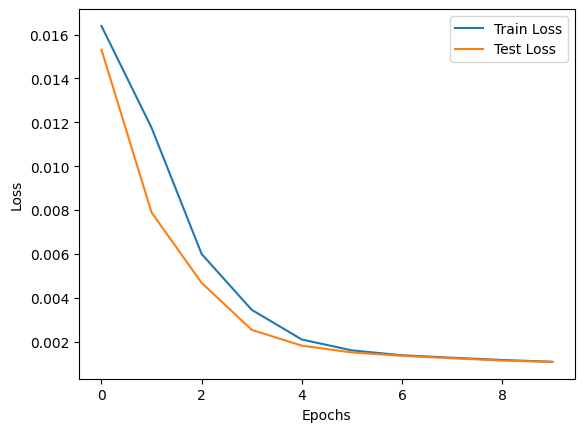

In [15]:
# Determine if CUDA is available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the number of epochs for training
epochs = 10

# Initialize lists to store loss values for each epoch
train_loss_list = []
test_loss_list = []

# Training loop 
for epoch in range(epochs):
    # Train the model on the training data and get the training loss
    train_loss = train(model, train_loader, optimizer, criterion, reshape=False)
    
    # Test the model on the testing data and get the testing loss
    test_loss = test(model, test_loader, criterion, reshape=False)

    # Append the training and testing loss for this epoch to their respective lists
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

# Plotting the loss curve

# Plot the training loss over epochs
plt.plot(train_loss_list, label='Train Loss')

# Plot the testing loss over epochs
plt.plot(test_loss_list, label='Test Loss')

# Label the x-axis as 'Epochs'
plt.xlabel('Epochs')

# Label the y-axis as 'Loss'
plt.ylabel('Loss')

# Display the legend
plt.legend()

# Show the plot
plt.show()

# Results with test

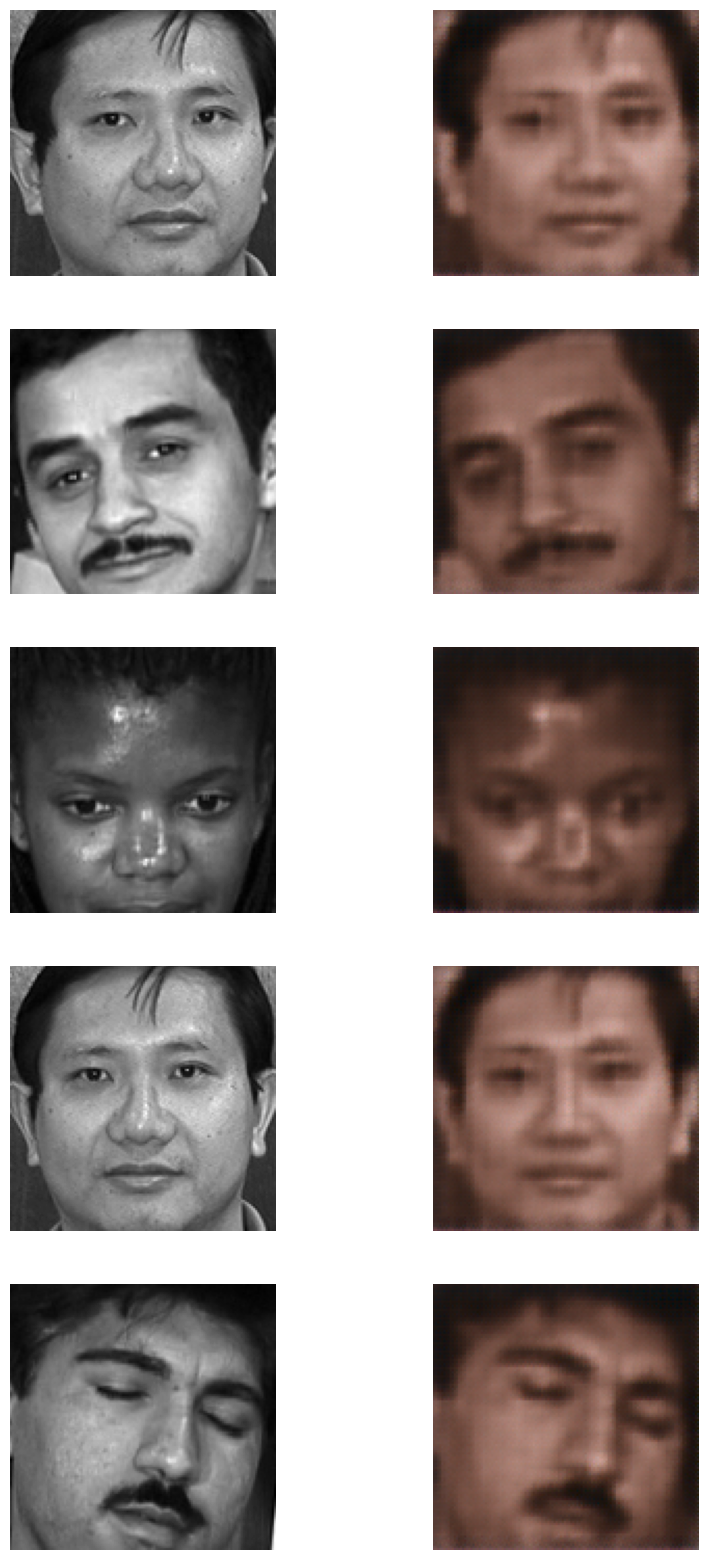

In [16]:
# Set the model to evaluation mode
model.eval()

# Randomly select some test images
test_images = random.sample(image_files, 5)

# Set up a figure with 5 rows (one for each image) and 2 columns (for grayscale and color images)
fig, axs = plt.subplots(5, 2, figsize=(10, 20))

# Iterate over the selected test images
for i, image_name in enumerate(test_images):
    # Load the grayscale image
    image_path = os.path.join(dataset_folder_path, image_name)
    gray_image = Image.open(image_path).convert("L")
    
    # Display the grayscale image
    axs[i, 0].imshow(gray_image, cmap="gray")
    axs[i, 0].axis('off')  # Hide axes

    # Preprocess the grayscale image
    gray_image = transform(gray_image).unsqueeze(0).to(device)

    # Pass the grayscale image through the model to obtain the reconstructed colored image
    with torch.no_grad():
        colored_image = model(gray_image)
        
    # Convert the output tensor to a CPU tensor and then to a NumPy array
    colored_image = colored_image.squeeze(0).cpu()
    numpy_image = np.transpose(colored_image.numpy(),axes = (1,2,0))
    
    # Convert the output tensor to an image in the LAB color space, then convert to RGB
    numpy_image = (numpy_image * 255).astype(np.uint8)
    rgb_image = cv2.cvtColor(numpy_image, cv2.COLOR_LAB2RGB)
    
    # Display the colored image
    axs[i, 1].imshow(rgb_image)
    axs[i, 1].axis('off')  # Hide axes

# Display the figure
plt.show()